In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE

In [3]:
architecture = getattr(models, "LinearOneLayer")

model = architecture.base(num_classes=10, **architecture.kwargs)

In [4]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

You are going to run models on the test set. Are you sure?


In [5]:
architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
m = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve3/checkpoint-12.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/curve4/checkpoint-12.pt')['model_state'])

In [6]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [7]:
def get_vector(model1):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    return par1

In [8]:
def samples(model):
    p1 = list(model.parameters())[0].data.numpy()
    p2 = list(model.parameters())[1].data.numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

## Making dataset 

In [9]:
ind = 1
T = True
S = []
B = []
while ind<20:

    ckpt = 'curves_mnist/LinearOneLayer/curve'+str(2+ind)+'/checkpoint-12.pt'
    checkpoint = torch.load(ckpt)
    m.load_state_dict(checkpoint['model_state'])
    
    S.append(samples(m))
    B.append(list(m.parameters())[-1].data.numpy())
    ind+=1
    
S = np.concatenate(S)

In [10]:
S.shape

(38000, 795)

## Generator 

## Flow Generator 

In [78]:
class SNet(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(SNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            nn.LeakyReLU(),
            nn.Linear(dim_middle, dim_middle),
            nn.LeakyReLU(),
            nn.Linear(dim_middle, dim_in)
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x
    
class TNet(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(TNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            nn.LeakyReLU(),
            nn.Linear(dim_middle, dim_middle),
            nn.LeakyReLU(),
            nn.Linear(dim_middle, dim_in),
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x
    
class SNetF(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(SNetF, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            nn.LeakyReLU(),
            nn.Linear(dim_middle, dim_middle),
            nn.LeakyReLU(),
            nn.Linear(dim_middle, dim_in)
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x
    
class TNetF(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(TNetF, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            nn.LeakyReLU(),
            nn.Linear(dim_middle, dim_middle),
            nn.LeakyReLU(),
            nn.Linear(dim_middle, dim_in),
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x

In [79]:
nets = SNet# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
nett = TNet# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
# ex_nets = nets(dim_in, dim_middle)
# ex_mett = nett(dim_in, dim_middle)

In [80]:
import numpy as np
N_layers = 3
n_dim = 795
onezero = [0, 1]*n_dim
masks = torch.Tensor([[onezero[:n_dim], onezero[1:n_dim+1]]]*N_layers)
masks = masks.view(2*N_layers, -1)

In [81]:
len(masks)

6

In [82]:
masks

tensor([[0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 1.]])

In [83]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(795), torch.eye(795))

In [170]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior 
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett(dim_in=795, dim_middle=795*2) for _ in range(len(mask)-1)]+[SNetF(dim_in=795, dim_middle=795*2)])
        self.s = torch.nn.ModuleList([nets(dim_in=795, dim_middle=795*2) for _ in range(len(mask)-1)]+[TNetF(dim_in=795, dim_middle=795*2)])
        
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        for i, (s, t) in enumerate(zip(reversed(self.s), reversed(self.t))):
            m = self.mask[-i-1]
#             print('i', i, 'm', m)
#             print('z', z.shape)
            z = m*z +(1-m)*(z-t(m*z))*(-s(m*z)).exp()
        x = z
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        log_det_J = 0
        for s, t, m in zip(self.s, self.t, self.mask):
#             print(m.shape, z.shape)
            s_res = s(m*z)
            z = m*z +(1-m)*(z*s_res.exp()+t(m*z))
            log_det_J += ((1-m)*s_res).sum(-1)
        
        return z, log_det_J
    
    def log_prob(self,x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        
        logp = -0.5*np.log(np.pi*2)-0.5*z.pow(2)
        logp = logp.sum(-1)
        
#         shape = torch.Size((K, self.in_dim))
#         logp = torch.cuda.FloatTensor(x.shape[0])
#         self.prior.log_prob(z.cpu(), out=logp)
        
#         logp = self.prior.log_prob(z.cpu()).cuda()
#         print('logp', logp.shape)
        
        return logp+log_det_J
        
    def sample(self, K): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)

        z = self.prior.sample((K, )).cuda()
        x = self.g(z)
        
        return x

In [171]:
flow = RealNVP(nets, nett, masks, prior)
flow.cuda();

In [172]:
def iterate_minibatches(train_data, batchsize):
    indices = np.random.permutation(np.arange(len(train_data)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield torch.FloatTensor(train_data[ix]).cuda()

In [269]:
flow.cuda();
trainable_parametrs = filter(lambda param: param.requires_grad, flow.parameters()) # list of all trainable parameters in a flow
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4)# choose an optimizer, use module torch.optim

for epoch in range(50):   
    
    t = time.time()
    
    for X in iterate_minibatches(S, 256):
        
        loss = -flow.log_prob(X).mean() #  compute the maximum-likelihood loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print('epoch %s:' % epoch, 'loss = %.3f' % loss, 'time = %.2f' %  (time.time()-t))


epoch 0: loss = -1522.291 time = 4.59
epoch 1: loss = -1601.309 time = 4.58
epoch 2: loss = -1638.143 time = 4.58
epoch 3: loss = -1674.071 time = 4.58
epoch 4: loss = -1679.598 time = 4.58
epoch 5: loss = -1699.214 time = 4.59
epoch 6: loss = -1705.548 time = 4.59
epoch 7: loss = -1716.008 time = 4.59
epoch 8: loss = -1730.835 time = 4.59
epoch 9: loss = -1744.234 time = 4.59


KeyboardInterrupt: 

In [238]:
i, j = 1, 500
flow.g(flow.f(X)[0])[i][j], X[i][j]

(tensor(-0.0080, device='cuda:0', grad_fn=<SelectBackward>),
 tensor(-0.0080, device='cuda:0'))

In [239]:
flow.cuda();

In [240]:
N = 2000
X = torch.FloatTensor(S[:N]).cuda()
X_sample = X.data.cpu().numpy()
X_prior = prior.sample((N,)).cpu().data.numpy()
X_flow = flow.sample(N, ).data.cpu().numpy()
X_sample_prior = flow.f(torch.FloatTensor(X_sample).cuda())[0].data.cpu().numpy()

In [241]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['figure.dpi'] = 50

In [242]:
# sns.kdeplot(X_sample[:, i], X_sample[:, j], shade=True,  cbar=True)

In [243]:
# sns.kdeplot(X_flow[:, i], X_flow[:, j], shade=True,  cbar=True)

In [251]:
# sns.kdeplot(X_prior[:, i], X_prior[:, j], shade=True,  cbar=True)

In [250]:
# sns.kdeplot(X_sample_prior[:, i], X_sample_prior[:, j], shade=True,  cbar=True)

In [246]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['figure.dpi'] = 100

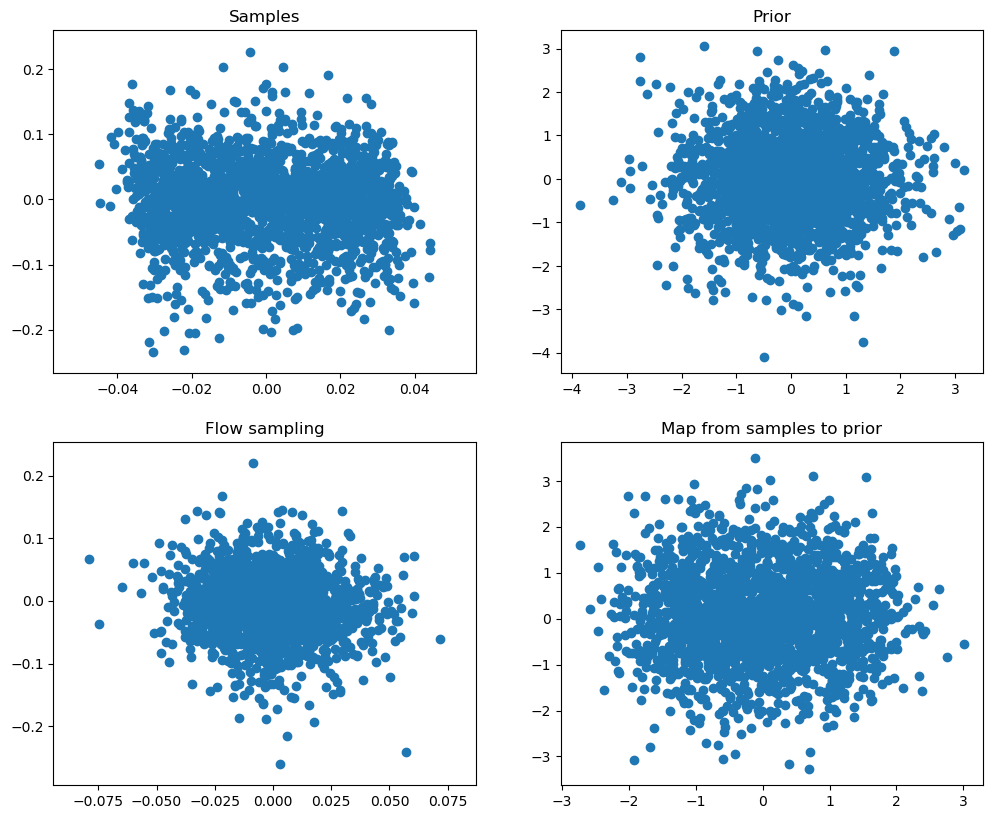

In [247]:
i, j = 500, -1
fig, axes = plt.subplots(2, 2,)
axes[0, 0].set_title('Samples')
axes[0, 0].scatter(X_sample[:, i], X_sample[:, j])
axes[0, 1].set_title('Prior')
axes[0, 1].scatter(X_prior[:, i], X_prior[:, j])
axes[1, 0].set_title('Flow sampling')
axes[1, 0].scatter(X_flow[:, i], X_flow[:, j])
axes[1, 1].set_title('Map from samples to prior')
axes[1, 1].scatter(X_sample_prior[:, i], X_sample_prior[:, j]) 
plt.show()

In [252]:
W1 = samples(model1)
W2 = samples(model2)
W1.shape, W2.shape

((2000, 795), (2000, 795))

In [253]:
flow.cpu()
W_pre = 1/np.sqrt(2)*flow.f(torch.FloatTensor(W1))[0]+1/np.sqrt(2)*flow.f(torch.FloatTensor(W2))[0]
W = flow.g(W_pre)

In [254]:
# W_pre = 1/np.sqrt(2)*flow.f(torch.FloatTensor(W1).cuda())[0]+1/np.sqrt(2)*flow.f(torch.FloatTensor(W2).cuda())[0]
# W = flow.g(W_pre)

In [255]:
# X_prior = W_pre[:N].cpu().data.numpy()
# X_sample = W[:N].cpu().data.numpy()

# i, j = 500, -1
# fig, axes = plt.subplots(2, 2,)
# axes[0, 0].set_title('Samples')
# axes[0, 0].scatter(X_sample[:, i], X_sample[:, j])
# axes[0, 1].set_title('Prior')
# axes[0, 1].scatter(X_prior[:, i], X_prior[:, j])
# plt.show()

In [256]:
W.shape

torch.Size([2000, 795])

In [257]:
B = []
B.append(list(model1.parameters())[-1].data.numpy())
B.append(list(model2.parameters())[-1].data.numpy())
B = np.array(B)

In [258]:
B[0]

array([-0.14534715,  0.14893281, -0.01729663, -0.10356466, -0.00152205,
        0.17101075, -0.00292133,  0.10191716, -0.11753058, -0.00322389],
      dtype=float32)

In [259]:
def get_model(W, B):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = W.cpu().data.numpy()
    SIZE = 2000

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(torch.from_numpy(B.mean(0)))
    
    return model_sampled

In [260]:
model_samples = get_model(W, B)

In [261]:
criterion = F.cross_entropy
regularizer = None 

In [262]:
model_sampled = get_model(W, B)

In [272]:
def test(model):
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

In [273]:
test(model_sampled)

{'nll': 0.18562655256589253, 'loss': 0.18562655256589253, 'accuracy': 94.97166666666666}
{'nll': 0.19069762821197508, 'loss': 0.19069762821197508, 'accuracy': 94.57}


In [264]:
flow.cuda();
X_flow = flow.sample(N, ).data.cpu()

In [265]:
X_flow.shape

torch.Size([2000, 795])

In [266]:
model_flow = get_model(X_flow, B)

In [267]:
test(model_flow)

({'nll': 0.38163312414487205, 'loss': 0.38163312414487205, 'accuracy': 87.59},
 {'nll': 0.37870460305213927, 'loss': 0.37870460305213927, 'accuracy': 87.62})

In [153]:
test(model1)

({'nll': 0.09569888906478882, 'loss': 0.09569888906478882, 'accuracy': 97.49},
 {'nll': 0.1064903314590454, 'loss': 0.1064903314590454, 'accuracy': 96.85})

In [69]:
class Gaussian_Flow(nn.Module):
    def __init__(self, n_dim=795, N_layers=2):
        super(Gaussian_Flow, self).__init__()
        
        onezero = [0, 1]*n_dim
        masks = torch.Tensor([[onezero[:n_dim], onezero[1:n_dim+1]]]*N_layers)
        masks = masks.view(2*N_layers, -1)
#         print('masks', masks, masks.shape)
        prior = distributions.MultivariateNormal(torch.zeros(n_dim), torch.eye(n_dim))
        
        self.nvp = RealNVP(nets, nett, masks, prior)
        self.relu = nn.ReLU()
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)


    def forward(self, x, K=2000):

        x = x.view(x.size(0), -1)
        W = self.nvp.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        print('x', x.shape)
        print('W1', W1.shape)
        print('b1', b1.shape)
        x = F.linear(x, W1, b1[:, 0])
        print('x', x.shape)
#         x = W1 @ x #+ b1
        print(x.shape)
        x = self.relu(x)
#         print('W2', W2.shape)
        x = F.linear(x, W2, self.b2) 
        x = 1/K*x
        print(x.shape)
        return x

In [51]:
GF = Gaussian_Flow(n_dim=795, N_layers=1)

In [52]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, GF.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [53]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GF, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GF, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

x torch.Size([128, 784])
W1 torch.Size([2000, 784])
b1 torch.Size([2000, 1])
x torch.Size([128, 2000])
torch.Size([128, 2000])
torch.Size([128, 10])


Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

## Trainig mean and covariance matrix One hidden layer

In [18]:
class Gaussian_model(nn.Module):
    def __init__(self, n_dim=795):
        super(Gaussian_model, self).__init__()
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        self.in_dim = n_dim
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)

    def sample(self, K, cuda=True):
        
        if cuda:
            shape = torch.Size((K, self.in_dim))
            e = torch.cuda.FloatTensor(shape)
            torch.randn(shape, out=e)   
        else:          
            e = torch.randn((K, self.in_dim))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=20000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        x = F.linear(x, W1, b1[:, 0])
        x = self.relu(x)
        x = F.linear(x, W2, self.b2) 
        x = 1/K*x

        return x

In [19]:
GM = Gaussian_model()
GM.cuda();

In [22]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, GM.parameters()),
    lr=0.01,
#     momentum=0.9,
)

In [23]:
columns = ['ep', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()


    train_res = utils.train(loaders['train'], GM, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], GM, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   0     0.3081    91.3167     0.2685    91.9900     7.5937
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   1     0.2685    92.0917     0.2484    93.2200     7.5749
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   2     0.2631    92.3567     0.2584    92.7600     7.6197
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   3     0.2607    92.3900     0.2583    92.8700     7.6181
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   4     0.2516    92.5583     0.2549    92.8400     7.6093
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  -

In [884]:
# GM(X)[0]

In [887]:
# test_res = utils.test(loaders['test'], GM, criterion, regularizer, cuda=True)
# test_res

In [260]:
samples = GM.sample(2000).data.numpy()
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


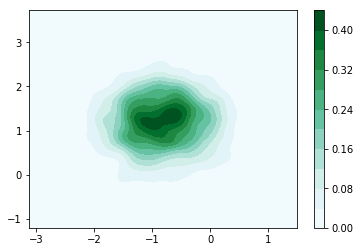

In [264]:
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

In [277]:
X_embeddeds = TSNE(n_components=2).fit_transform(samples)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


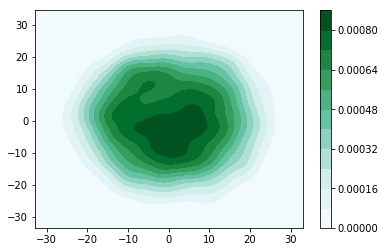

In [279]:
sns.kdeplot(X_embeddeds[:, 0], X_embeddeds[:, 1], shade=True,  cbar=True)

## Trainig mean and covariance matrix Several hidden layer

In [249]:
class GMMultyLayer(nn.Module):
    def __init__(self, n_dim=809):
        super(GMMultyLayer, self).__init__()
        self.n_dim = n_dim
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_bf = torch.FloatTensor(np.random.normal(size=(10, )))
        self.bf = nn.Parameter(data = data_bf, requires_grad=True)

    def sample(self, K):
        e = torch.randn((K, self.mean.size()[0]))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=4000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784]
        
        W2 = W[:, 785]
        b2 = W[:, 786]
        Wf =  W[:, -10:].transpose(0,1)
        
        x = F.linear(x, W1, b1)
        x = self.relu(x)
        for i in range(int(self.n_dim-784-10/2), 2):
            Wi = W[:, 785+i]
            bi = W[:, 786+i]
            x = self.relu(Wi*x+bi)
            
        x = F.linear(x, Wf, self.bf) 
        x = 1/K*x
#         print(x.shape)
        return x

In [250]:
GML = GMMultyLayer()

In [251]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, GML.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [252]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GML, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GML, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     2.7916    14.3017     2.2235    14.8000    93.5746
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0010     2.1833    15.8317     2.1439    18.0300    91.0075
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0010     2.0937    24.0500     2.0191    30.7600    90.9785
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0010     1.9095    36.9383     1.7213    47.6100    90.6315
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  